# Data Preprocessing

In [1]:
# Import libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("data/guardian_environment_news.csv")
df.head()

,Title,Intro Text,Authors,Article Text,Date Published
0,Liz Truss ‘will approve more oil drilling if ...,Tory leadership candidate criticised by campai...,"['Rob Davies', '@ByRobDavies']",Liz Truss will sign off on a push for more oil...,2022-08-30
1,Renewed Highland golf course plan has environm...,Scottish government rejected a new links at Co...,"['Ewan Murray', '@mrewanmurray']",It is an area so tranquil that the notion of b...,2021-03-22
2,Visiting green spaces deters mental health dr...,Positive effects were stronger among those rep...,"['Damien Gayle', '@damiengayle']","Visits to parks, community gardens and other u...",2023-01-17
3,Bought too much red cabbage? Turn it into a fe...,This fantastic vegan centrepiece makes full us...,['Tom Hunt'],"I devised today’s nut roast for Oddbox, a veg ...",2023-12-22
4,‘This year has been very good’: readers’ UK bu...,Readers share their favourite sightings over t...,['Guardian readers'],‘Constant companions to our gardening’A peacoc...,2023-12-19


In [3]:
# Feature Selection
# We choose the title, intro text and article text to perform clustering
# The goal of the clustering is to identify the similar news articles based on the title or the categories

In [4]:
# Drop unwanted columns
df = df.drop(["Authors", "Date Published"], axis=1)
df.head()

,Title,Intro Text,Article Text
0,Liz Truss ‘will approve more oil drilling if ...,Tory leadership candidate criticised by campai...,Liz Truss will sign off on a push for more oil...
1,Renewed Highland golf course plan has environm...,Scottish government rejected a new links at Co...,It is an area so tranquil that the notion of b...
2,Visiting green spaces deters mental health dr...,Positive effects were stronger among those rep...,"Visits to parks, community gardens and other u..."
3,Bought too much red cabbage? Turn it into a fe...,This fantastic vegan centrepiece makes full us...,"I devised today’s nut roast for Oddbox, a veg ..."
4,‘This year has been very good’: readers’ UK bu...,Readers share their favourite sightings over t...,‘Constant companions to our gardening’A peacoc...


In [5]:
# Combine the title, intro text and article text to get the full news article
df["article"] = df["Title"] + " " + df["Intro Text"] + " " + df["Article Text"]
df = df.drop(["Title", "Intro Text", "Article Text"], axis=1)
df.head()

,article
0,Liz Truss ‘will approve more oil drilling if ...
1,Renewed Highland golf course plan has environm...
2,Visiting green spaces deters mental health dr...
3,Bought too much red cabbage? Turn it into a fe...
4,‘This year has been very good’: readers’ UK bu...


In [6]:
df.shape

(30059, 1)

### Data Cleaning

In [7]:
# Remove the missing value
df = df.dropna()
df.head()

,article
0,Liz Truss ‘will approve more oil drilling if ...
1,Renewed Highland golf course plan has environm...
2,Visiting green spaces deters mental health dr...
3,Bought too much red cabbage? Turn it into a fe...
4,‘This year has been very good’: readers’ UK bu...


In [8]:
df = df.drop_duplicates()
df.head()

,article
0,Liz Truss ‘will approve more oil drilling if ...
1,Renewed Highland golf course plan has environm...
2,Visiting green spaces deters mental health dr...
3,Bought too much red cabbage? Turn it into a fe...
4,‘This year has been very good’: readers’ UK bu...


In [9]:
# Remove extremely short or long documents
df["Text_Length"] = df["article"].apply(lambda x: len(x.split()))

# Define length thresholds
min_length = df["Text_Length"].quantile(0.2)
max_length = df["Text_Length"].quantile(0.8)

df = df[(df["Text_Length"] > min_length) & (df["Text_Length"] < max_length)]
df.head()

,article,Text_Length
2,Visiting green spaces deters mental health dr...,593
3,Bought too much red cabbage? Turn it into a fe...,542
4,‘This year has been very good’: readers’ UK bu...,941
6,Scaly stowaway: lizard makes an appearance at...,657
8,UK energy industry urges ministers to stick w...,806


In [10]:
df.shape

(17181, 2)

In [11]:
# Remove documents with high word repetition
# Detect spam-like text
def word_repetition(text):
    words = text.split()
    word_counts = Counter(words)
    most_common_word, most_common_count = word_counts.most_common(1)[0]
    return most_common_count / len(words)

df["Repetition_Ratio"] = df["article"].apply(word_repetition)
df = df[(df["Repetition_Ratio"] < 0.06) & (df["Repetition_Ratio"] > 0.045)]
df.head()

,article,Text_Length,Repetition_Ratio
3,Bought too much red cabbage? Turn it into a fe...,542,0.047970
6,Scaly stowaway: lizard makes an appearance at...,657,0.059361
8,UK energy industry urges ministers to stick w...,806,0.050868
16,"This article is more than 11 months oldFood, ...",765,0.045752
17,This article is more than 4 months oldUS behi...,902,0.057650


In [12]:
df.shape

(8187, 3)

In [13]:
df = df.astype(str)
df.dtypes

article             object
Text_Length         object
Repetition_Ratio    object
dtype: object

### Text Preprocessing

##### Text Cleaning

In [14]:
# Text Cleanning Function
def clean_text(text):
    # Convert into lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra blanks
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [15]:
df["article"] = df["article"].map(clean_text)
print(df["article"])

3        bought too much red cabbage turn it into a fes...
6        scaly stowaway lizard makes an appearance at c...
8        uk energy industry urges ministers to stick wi...
16       this article is more than months oldfood feed ...
17       this article is more than months oldus behind ...
                               ...                        
30038    capitalism is part of solution to climate cris...
30040    of course i m hot for the return of wrestling ...
30042    country diary seal remains show nature is not ...
30050    bhp faces fresh calls to quit minerals council...
30054    climate change could make insurance too expens...
Name: article, Length: 8187, dtype: object


##### Tokenization with Stopword Removal

In [16]:
# Initialize Treebank tokenizer
tokenizer = TreebankWordTokenizer()

# Get English stopwords
stop_words = set(stopwords.words("english"))

# Tokenization function
def tokenize_tokens(text):
    tokens = tokenizer.tokenize(text) 
    filtered_tokens = []
    
    for word in tokens:
        if word.lower() in stop_words:
            continue
        else:
            filtered_tokens.append(word)
    
    return filtered_tokens

df["article"] = df["article"].apply(tokenize_tokens)

print(df["article"])


3        [bought, much, red, cabbage, turn, festive, nu...
6        [scaly, stowaway, lizard, makes, appearance, c...
8        [uk, energy, industry, urges, ministers, stick...
16       [article, months, oldfood, feed, fuel, global,...
17       [article, months, oldus, behind, third, global...
                               ...                        
30038    [capitalism, part, solution, climate, crisis, ...
30040    [course, hot, return, wrestling, eastenders, l...
30042    [country, diary, seal, remains, show, nature, ...
30050    [bhp, faces, fresh, calls, quit, minerals, cou...
30054    [climate, change, could, make, insurance, expe...
Name: article, Length: 8187, dtype: object


##### Stemming and Lemmatization

In [17]:
# Stemming
# Since stemming is rule based and can lead to inaccurate word root form, 
# we just apply it to visualize the result first
def stemming_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

df["stem_article"] = df["article"].apply(stemming_tokens)

print(df["stem_article"])

3        [bought, much, red, cabbag, turn, festiv, nut,...
6        [scali, stowaway, lizard, make, appear, chelse...
8        [uk, energi, industri, urg, minist, stick, net...
16       [articl, month, oldfood, feed, fuel, global, s...
17       [articl, month, oldu, behind, third, global, o...
                               ...                        
30038    [capit, part, solut, climat, crisi, say, mark,...
30040    [cours, hot, return, wrestl, eastend, legendal...
30042    [countri, diari, seal, remain, show, natur, se...
30050    [bhp, face, fresh, call, quit, miner, council,...
30054    [climat, chang, could, make, insur, expens, pe...
Name: stem_article, Length: 8187, dtype: object


In [18]:
# Lemmatization
# As lemmatization can bring to a more accurate word in base form, 
# Thus, we direct to apply lemmatization on the article
def lemmatizing_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return ' '.join(lemmatized_tokens)

df["article"] = df["article"].apply(lemmatizing_tokens)

print(df["article"])


3        buy much red cabbage turn festive nut roast re...
6        scaly stowaway lizard make appearance chelsea ...
8        uk energy industry urge minister stick net zer...
16       article months oldfood fee fuel global seaweed...
17       article months oldus behind third global oil g...
                               ...                        
30038    capitalism part solution climate crisis say ma...
30040    course hot return wrestle eastenders legendale...
30042    country diary seal remain show nature sentimen...
30050    bhp face fresh call quit minerals council ahea...
30054    climate change could make insurance expensive ...
Name: article, Length: 8187, dtype: object


In [19]:
df = df.drop(['stem_article'], axis=1)
df.head()

,article,Text_Length,Repetition_Ratio
3,buy much red cabbage turn festive nut roast re...,542,0.04797047970479705
6,scaly stowaway lizard make appearance chelsea ...,657,0.0593607305936073
8,uk energy industry urge minister stick net zer...,806,0.05086848635235732
16,article months oldfood fee fuel global seaweed...,765,0.0457516339869281
17,article months oldus behind third global oil g...,902,0.057649667405764965


### Feature Engineering

##### Term Frequency-Inverse Document Frequency (TF-IDF)
Best for the text clustering and document classification

In [20]:
# Define TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)  # Increased features

# Applying TF-IDF
tfidf_matrix = vectorizer.fit_transform(df['article'])  

feature_names = vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display a sample of the transformed data
tfidf_df.head()

,abandon,abbott,abc,ability,able,aboriginal,abroad,absence,absolute,absolutely,...,yosemite,young,younger,youth,youtube,zealand,zero,zone,zoo,zoos
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.039548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.199614,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.051378,0.0,0.0,0.0


In [21]:
# Save to CSV file
tfidf_df.to_csv("data/tfidf_words_lemmatized.csv", index=False)

print("TF-IDF words saved to 'tfidf_words_lemmatized.csv'")

TF-IDF words saved to 'tfidf_words_lemmatized.csv'


##### Word Embeddings
Best for finding similar words and performing NLP tasks

In [22]:
df["tokens"] = df["article"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=df["tokens"], vector_size=100, window=5, min_count=2, workers=4)

# Save the model
word2vec_model.save("word2vec_model.model")

In [23]:
# Test the saved model
similar_words = word2vec_model.wv.most_similar("environment", topn=10)
words = [word for word, _ in similar_words]
words.append("environment") 
word_vectors = np.array([word2vec_model.wv[word] for word in words])

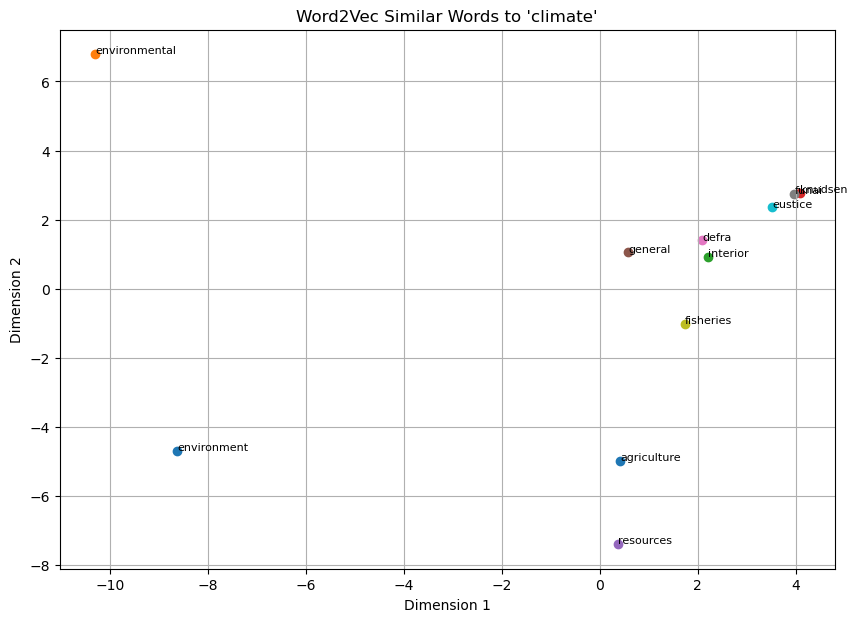

In [24]:
# Visualize the similar word
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

plt.figure(figsize=(10, 7))
for i, word in enumerate(words):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
    plt.text(reduced_vectors[i, 0]+0.01, reduced_vectors[i, 1]+0.01, word, fontsize=8)

plt.title("Word2Vec Similar Words to 'climate'")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

### Save into CSV file for Future use

In [25]:
df.drop(['tokens'], axis=1)

,article,Text_Length,Repetition_Ratio
3,buy much red cabbage turn festive nut roast re...,542,0.04797047970479705
6,scaly stowaway lizard make appearance chelsea ...,657,0.0593607305936073
8,uk energy industry urge minister stick net zer...,806,0.05086848635235732
16,article months oldfood fee fuel global seaweed...,765,0.0457516339869281
17,article months oldus behind third global oil g...,902,0.057649667405764965
...,...,...,...
30038,capitalism part solution climate crisis say ma...,529,0.05671077504725898
30040,course hot return wrestle eastenders legendale...,948,0.0580168776371308
30042,country diary seal remain show nature sentimen...,450,0.057777777777777775
30050,bhp face fresh call quit minerals council ahea...,822,0.052311435523114354


In [26]:
# Save as csv file
output_file = "data/processed_data.csv"
df.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

Processed data saved to data/processed_data.csv


In [27]:
data = df["article"]
output_file = "data/model_data.csv"
data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

Processed data saved to data/model_data.csv
